# Knowledge-primed Neural Networks (KPNNs) for single cell data

In this tutorial we will show how CORNETO can be used to build custom neural network architectures informed by prior knowledge. We will see how to implement a knowledge-primed neural network<sup>1</sup>. We will use the single cell data from the publication "Knowledge-primed neural networks enable biologically interpretable deep learning on single-cell sequencing data", from Nikolaus Fortelny & Christoph Bock, where they used a single-cell RNA-seq dataset they previously generated<sup>2</sup>, which measures cellular responses to T cell receptor (TCR) stimulation in a standardized in vitro model. The dataset was chosen due to the TCR signaling pathway's complexity and its well-characterized role in orchestrating transcriptional responses to antigen detection in T cells.

## Why CORNETO?

In the original publication, authors built a KPNN by searching on databases, building a Direct Acyclic Graph (DAG) by running shortest paths from TCR receptor to genes. However, this approach is not optimal. CORNETO, thanks to its advanced capabilities for modeling and optimization on networks, provides methods to automatically find DAG architectures in an optimal way. 

In addition to this, CORNETO provides methods to build DAG NN architectures with ease using Keras +3, making KPNN implementation very flexible and interoperable with backends like Pytorch, Tensorflow and JAX.

## How does it work?

Thanks to CORNETO's building blocks for optimization over networks, we can easily model optimization problems to find DAG architectures from a Prior Knowledge Network. After we have the backbone, we can convert it to a neural network using the utility functions included in CORNETO.


## References
1. Fortelny, N., & Bock, C. (2020). Knowledge-primed neural networks enable biologically interpretable deep learning on single-cell sequencing data. Genome biology, 21, 1-36.
2. Datlinger, P., Rendeiro, A. F., Schmidl, C., Krausgruber, T., Traxler, P., Klughammer, J., ... & Bock, C. (2017). Pooled CRISPR screening with single-cell transcriptome readout. Nature methods, 14(3), 297-301.



## Download and import the single cell dataset

In [1]:
import os
import urllib.request
import urllib.parse
import tempfile
import pandas as pd
import scanpy as sc
import numpy as np
import corneto as cn

with urllib.request.urlopen("http://kpnn.computational-epigenetics.org/") as response:
    web_input = response.geturl()
print("Effective URL:", web_input)

files = ["TCR_Edgelist.csv", "TCR_ClassLabels.csv", "TCR_Data.h5"]

temp_dir = tempfile.mkdtemp()

# Download files
file_paths = []
for file in files:
    url = urllib.parse.urljoin(web_input, file)
    output_path = os.path.join(temp_dir, file)
    print(f"Downloading {url} to {output_path}")
    try:
        with urllib.request.urlopen(url) as response:
            with open(output_path, 'wb') as f:
                f.write(response.read())
        file_paths.append(output_path)
    except Exception as e:
        print(f"Failed to download {url}: {e}")

print("Downloaded files:")
for path in file_paths:
    print(path)

Effective URL: https://medical-epigenomics.org/papers/fortelny2019/
Downloaded files:
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpqxsxf9p3/TCR_Edgelist.csv
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpqxsxf9p3/TCR_ClassLabels.csv
/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmpqxsxf9p3/TCR_Data.h5


In [2]:
# The data contains also the original network they built with shortest paths.
# We will use it to replicate the study
df_edges = pd.read_csv(file_paths[0])
df_labels = pd.read_csv(file_paths[1])
# Import the 10x data with Scanpy
adata = sc.read_10x_h5(file_paths[2])

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
df_labels

,barcode,TCR
0,AAACCTGCACACATGT-1,0
1,AAACCTGCACGTCTCT-1,0
2,AAACCTGTCAATACCG-1,0
3,AAACCTGTCGTGGTCG-1,0
4,AAACGGGTCTGAGTGT-1,0
...,...,...
1730,TTTCCTCGTCATGCCG-2,1
1731,TTTGCGCGTAGCCTCG-2,1
1732,TTTGGTTAGATACACA-2,1
1733,TTTGGTTGTATGAATG-2,1


In [4]:
df_edges

,parent,child
0,TCR,ZAP70
1,ZAP70,MAPK14
2,MAPK14,FOXO3
3,MAPK14,STAT1
4,MAPK14,STAT3
...,...,...
27574,HMGA1,MTRNR2L9_gene
27575,MYB,C12orf50_gene
27576,MYB,TRPC5OS_gene
27577,SOX2,TRPC5OS_gene


In [5]:
adata.var

,gene_ids
DDX11L1,ENSG00000223972
WASH7P,ENSG00000227232
MIR6859-2,ENSG00000278267
MIR1302-10,ENSG00000243485
MIR1302-11,ENSG00000274890
...,...
Tcrlibrary_RUNX2_3_gene,Tcrlibrary_RUNX2_3_gene
Tcrlibrary_ZAP70_1_gene,Tcrlibrary_ZAP70_1_gene
Tcrlibrary_ZAP70_2_gene,Tcrlibrary_ZAP70_2_gene
Tcrlibrary_ZAP70_3_gene,Tcrlibrary_ZAP70_3_gene


In [6]:
# We can normalize the data, however, it is better to avoid
# preprocessing the whole dataset before splitting in training and test
# to avoid data leakage.
# NOTE: Normalization can be done inside the cross-val loop
# sc.pp.normalize_total(adata, target_sum=1e6)

# Log-transform the data does not leak data as it does not estimate anything
sc.pp.log1p(adata)

In [7]:
adata.obs

""
AAACCTGAGAAACCAT-1
AAACCTGAGAAACCGC-1
AAACCTGAGAAACCTA-1
AAACCTGAGAAACGAG-1
AAACCTGAGAAACGCC-1
...
TTTGTCATCTTTACAC-2
TTTGTCATCTTTACGT-2
TTTGTCATCTTTAGGG-2
TTTGTCATCTTTAGTC-2


In [8]:
barcodes = adata.obs_names
barcodes

Index(['AAACCTGAGAAACCAT-1', 'AAACCTGAGAAACCGC-1', 'AAACCTGAGAAACCTA-1',
       'AAACCTGAGAAACGAG-1', 'AAACCTGAGAAACGCC-1', 'AAACCTGAGAAAGTGG-1',
       'AAACCTGAGAACAACT-1', 'AAACCTGAGAACAATC-1', 'AAACCTGAGAACTCGG-1',
       'AAACCTGAGAACTGTA-1',
       ...
       'TTTGTCATCTTGGGTA-2', 'TTTGTCATCTTGTACT-2', 'TTTGTCATCTTGTATC-2',
       'TTTGTCATCTTGTCAT-2', 'TTTGTCATCTTGTTTG-2', 'TTTGTCATCTTTACAC-2',
       'TTTGTCATCTTTACGT-2', 'TTTGTCATCTTTAGGG-2', 'TTTGTCATCTTTAGTC-2',
       'TTTGTCATCTTTCCTC-2'],
      dtype='object', length=1474560)

In [9]:
gene_names = adata.var.index
print(gene_names)

Index(['DDX11L1', 'WASH7P', 'MIR6859-2', 'MIR1302-10', 'MIR1302-11', 'FAM138A',
       'OR4G4P', 'OR4G11P', 'OR4F5', 'RP11-34P13.7',
       ...
       'Tcrlibrary_RUNX1_1_gene', 'Tcrlibrary_RUNX1_2_gene',
       'Tcrlibrary_RUNX1_3_gene', 'Tcrlibrary_RUNX2_1_gene',
       'Tcrlibrary_RUNX2_2_gene', 'Tcrlibrary_RUNX2_3_gene',
       'Tcrlibrary_ZAP70_1_gene', 'Tcrlibrary_ZAP70_2_gene',
       'Tcrlibrary_ZAP70_3_gene', 'Cas9_blast_gene'],
      dtype='object', length=64370)


In [10]:
len(set(df_labels.barcode.tolist()))

1735

In [11]:
len(set(barcodes.tolist()))

1474560

In [12]:
matched_barcodes = sorted(set(barcodes.tolist()) & set(df_labels.barcode.tolist()))
len(matched_barcodes)

1735

In [13]:
#This is the InPathsY data in the original code of KPNNs
df_labels

,barcode,TCR
0,AAACCTGCACACATGT-1,0
1,AAACCTGCACGTCTCT-1,0
2,AAACCTGTCAATACCG-1,0
3,AAACCTGTCGTGGTCG-1,0
4,AAACGGGTCTGAGTGT-1,0
...,...,...
1730,TTTCCTCGTCATGCCG-2,1
1731,TTTGCGCGTAGCCTCG-2,1
1732,TTTGGTTAGATACACA-2,1
1733,TTTGGTTGTATGAATG-2,1


## Import PKN with CORNETO


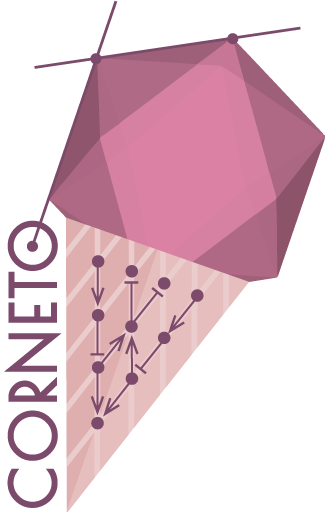

In [14]:
import corneto as cn
cn.info()

In [15]:
outputs_pkn = list(set(df_edges.parent.tolist()) - set(df_edges.child.tolist()))
inputs_pkn = set(df_edges.child.tolist()) - set(df_edges.parent.tolist())
input_pkn_genes = list(set(g.split("_")[0] for g in inputs_pkn))
len(inputs_pkn), len(outputs_pkn)

(13121, 1)

In [16]:
tuples = [(r.child, 1, r.parent) for _, r in df_edges.iterrows()]
G = cn.Graph.from_sif_tuples(tuples)
G = G.prune(inputs_pkn, outputs_pkn)

# Size of the original PKN provided by the authors
G.shape

(13439, 27579)

## Select the single cell data for training

In [17]:
adata_matched = adata[adata.obs_names.isin(matched_barcodes), adata.var_names.isin(input_pkn_genes)]
adata_matched.shape

(1735, 14229)

In [18]:
non_zero_genes = set(adata_matched.to_df().columns[adata_matched.to_df().sum(axis=0) >= 1e-6].values)
len(non_zero_genes)

12459

In [19]:
len(non_zero_genes.intersection(adata_matched.var_names))

12459

In [20]:
adata_matched = adata_matched[:, adata_matched.var_names.isin(non_zero_genes)]
# Many duplicates still 0 counts
adata_matched = adata_matched[:, adata_matched.to_df().sum(axis=0) != 0]
adata_matched.shape

(1735, 12487)

In [21]:
df_expr = adata_matched.to_df()
df_expr = df_expr.groupby(df_expr.columns, axis=1).max()
df_expr

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_2890/3016726407.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_expr = df_expr.groupby(df_expr.columns, axis=1).max()


,A1BG,A2ML1,AAAS,AACS,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP,...,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
AAACCTGCACACATGT-1,0.0,0.0,0.000000,0.693147,0.0,0.000000,0.000000,0.000000,0.0,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
AAACCTGCACGTCTCT-1,0.0,0.0,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.0,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
AAACCTGTCAATACCG-1,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
AAACCTGTCGTGGTCG-1,0.0,0.0,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.098612,...,0.000000,0.693147,0.000000,0.693147,0.0,0.0,0.0,0.000000,0.000000,0.000000
AAACGGGTCTGAGTGT-1,0.0,0.0,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.0,0.000000,...,0.693147,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCGTCATGCCG-2,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.693147,0.0,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
TTTGCGCGTAGCCTCG-2,0.0,0.0,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.386294,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
TTTGGTTAGATACACA-2,0.0,0.0,1.098612,0.000000,0.0,0.000000,0.000000,1.098612,0.0,0.693147,...,0.693147,0.000000,0.693147,0.000000,0.0,0.0,0.0,0.693147,0.693147,0.000000
TTTGGTTGTATGAATG-2,0.0,0.0,0.000000,0.000000,0.0,0.693147,1.098612,0.000000,0.0,0.693147,...,0.000000,0.693147,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.693147


## Building and training the KPNN

Now we will use the provided PKN by the authors and the utility functions in CORNETO to build a KPNN similar to the one used in the original manuscript

In [22]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [23]:
import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np

In [24]:
# Use the data from the experiment
X = df_expr.values
y = df_labels.set_index("barcode").loc[df_expr.index, "TCR"].values
X.shape, y.shape

((1735, 12459), (1735,))

In [25]:
# We can prefilter on top N genes to make this faster
top_n = None

# From the given PKN
outputs_pkn = list(set(df_edges.parent.tolist()) - set(df_edges.child.tolist()))
inputs_pkn = set(df_edges.child.tolist()) - set(df_edges.parent.tolist())
input_pkn_genes = list(set(g.split("_")[0] for g in inputs_pkn))

if top_n is not None and top_n > 0:
    input_pkn_genes = list(set(input_pkn_genes).intersection(df_expr.var(axis=0).sort_values(ascending=False).head(top_n).index))
    inputs_pkn = list(g + "_gene" for g in input_pkn_genes)

len(inputs_pkn), len(outputs_pkn)

(13121, 1)

In [26]:
input_nn_genes = list(set(input_pkn_genes).intersection(df_expr.columns))
input_nn = [g + "_gene" for g in input_nn_genes]
len(input_nn)

12459

In [27]:
# Build corneto graph
tuples = [(r.child, 1, r.parent) for _, r in df_edges.iterrows()]
G = cn.Graph.from_sif_tuples(tuples)
G = G.prune(input_nn, outputs_pkn)
G.shape

(12767, 25928)

In [28]:
len(input_nn), len(input_nn_genes)

(12459, 12459)

In [29]:
len(set(input_nn).intersection(G.V))

12459

In [30]:
X = df_expr.loc[:, input_nn_genes].values
y = df_labels.set_index("barcode").loc[df_expr.index, "TCR"].values
X.shape, y.shape

((1735, 12459), (1735,))

In [31]:
from corneto._ml import build_dagnn

def stratified_kfold(
    G,
    inputs,
    outputs,
    n_splits=5,
    shuffle=True,
    random_state=42,
    lr=0.001,
    patience=10,
    file_weights="weights",
    dagnn_config=dict(
        batch_norm_input=True,
        batch_norm_center=False,
        batch_norm_scale=False,
        bias_reg_l1=1e-3,
        bias_reg_l2=1e-2,
        dropout=0.20,
        default_hidden_activation="sigmoid",
        default_output_activation="sigmoid",
        verbose=False
    )
):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    models = []
    metrics = {m: [] for m in ["accuracy", "precision", "recall", "f1", "roc_auc"]}
    for i, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
    
        print("Building DAG NN model with CORNETO using Keras with JAX...")
        print(f" > N. inputs: {len(input_nn)}")
        print(f" > N. outputs: {len(outputs_pkn)}")
        model = build_dagnn(
            G, 
            input_nn, 
            outputs_pkn,
            **dagnn_config
        )
        print(f" > N. parameters: {model.count_params()}")
    
        # Train the model with Adam
        opt=keras.optimizers.Adam(learning_rate=lr)
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        print("Compiling...")
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        print("Fitting...")
        model.fit(X_train, y_train,
                  validation_data=(X_val, y_val),
                  epochs=200,
                  batch_size=64,
                  verbose=0,
                  callbacks=[early_stopping])
        
        if file_weights is not None:
            filename = f"{file_weights}_{i}.keras"
            model.save(filename)
            print(f"Weights saved to {filename}")
    
        # Predictions and metrics calculation
        y_pred_proba = model.predict(X_val).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        acc = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        metrics["accuracy"].append(acc)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1"].append(f1)
        metrics["roc_auc"].append(roc_auc)
        print(f" > Fold {i} validation ROC-AUC={roc_auc:.3f}")
        models.append(model)
    return models, metrics

temp_weights = tempfile.mkdtemp()
models, metrics = stratified_kfold(G, input_nn, outputs_pkn, file_weights=os.path.join(temp_weights, "weights"))

print("Validation metrics:")
for k, v in metrics.items():
    print(f" - {k}: {np.mean(v):.3f}")

Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 26236
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/weights_0.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
 > Fold 0 validation ROC-AUC=0.988
Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 26236
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/weights_1.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step
 > Fold 1 validation ROC-AUC=0.981
Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 26236
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/weights_2.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step
 > Fold 2 validation ROC-AUC=0.981
Building DAG NN model with CORNETO using Keras with JAX...

Now, we will analyze the learned biases for each of the nodes in the graph. Note that authors in the KPNN paper explain a way to extract weights for the nodes, based on the learned interactions and accounting for biases in the structure of the NN. Here we just show the learned biases of the nodes of the NN across 5 folds. Please be careful interpreting these weights.

In [32]:
# We collect the weights obtained in each fold

def load_biases(file="weights", folds=5):
    biases = []
    mean_inputs = []
    for i in range(5):
        model = keras.models.load_model(f"{file}_{i}.keras")
        for layer in model.layers:
            weights = layer.get_weights()
            if weights:
                biases.append((i, layer.name, weights[1][0]))
                mean_inputs.append((i, layer.name, weights[0].mean()))
    df_biases = pd.DataFrame(biases, columns=["fold", "gene", "bias"])
    df_biases["abs_bias"] = df_biases.bias.abs()
    df_biases["pow2_bias"] = df_biases.bias.pow(2)
    df_biases = df_biases.set_index(["fold","gene"])
    return df_biases

df_biases = load_biases(file=os.path.join(temp_weights, "weights"), folds=5)
df_biases.sort_values(by="abs_bias", ascending=False).head(10)

bias  abs_bias  pow2_bias
fold gene                                       
3    SUZ12.EZH2   -2.400931  2.400931   5.764470
1    SUZ12.EZH2   -2.391739  2.391739   5.720415
     DUSP3        -2.267709  2.267709   5.142504
2    ZAP70        -2.055808  2.055808   4.226345
3    PTPN1        -1.938718  1.938718   3.758628
2    NfKb.p65.p50 -1.914346  1.914346   3.664720
0    DUSP3        -1.891751  1.891751   3.578723
3    TCR           1.890686  1.890686   3.574695
4    TCR           1.779573  1.779573   3.166881
2    TCR          -1.737326  1.737326   3.018300

In [33]:
df_biases_full = df_biases.copy().reset_index()
gene_biases_score = df_biases_full.groupby("gene")["pow2_bias"].mean().sort_values(ascending=False)
gene_biases_score

gene
TCR             3.121737
SUZ12.EZH2      2.848315
DUSP3           2.216379
NfKb.p65.p50    1.609828
RUNX1           1.262357
                  ...   
HMT             0.000546
GATA3           0.000467
WT1             0.000326
SRY             0.000030
REST            0.000025
Name: pow2_bias, Length: 308, dtype: float32

<Axes: xlabel='gene'>

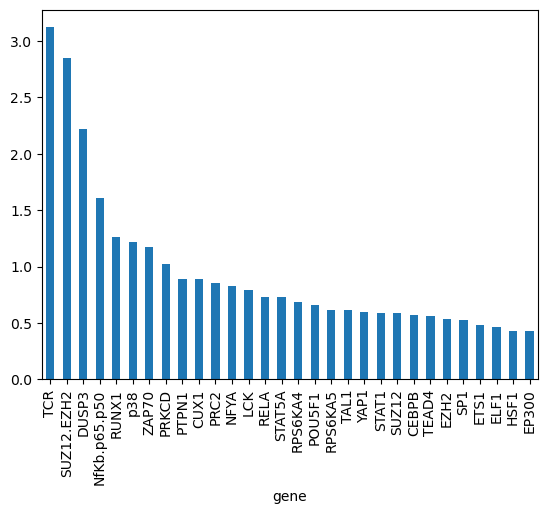

In [34]:
gene_biases_score.head(30).plot.bar()

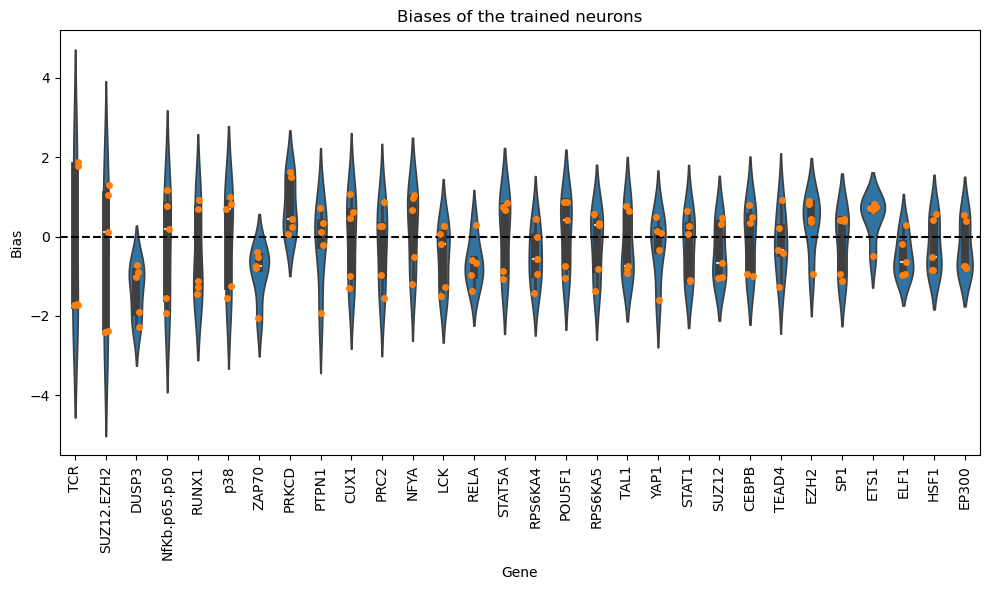

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top genes sorted by mean bias
top_genes = gene_biases_score.head(30).index

# Filter the DataFrame to include only rows with these top genes
filtered_df = df_biases_full[df_biases_full['gene'].isin(top_genes)]

plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x="gene", y="bias", order=top_genes, dodge=True)
sns.stripplot(data=filtered_df, x="gene", y="bias", order=top_genes, dodge=True)
plt.xticks(rotation=90)
plt.title('Biases of the trained neurons')
plt.xlabel('Gene')
plt.ylabel('Bias')
plt.axhline(0, linestyle="--", color="k")
plt.tight_layout()

## Use CORNETO for NN pruning

Now we will show how CORNETO can be used to extract a smaller, yet complete DAG from the original PKN provided by the authors. We will add input edges to each input node and an output edge through TCR to indicate which nodes are the inputs and which one the output. We will use then Acyclic Flow to find the smallest DAG comprising these nodes

In [36]:
G_dag = G.copy()
new_edges = []
for g in input_nn:
    new_edges.append(G_dag.add_edge((), g))
new_edges.append(G_dag.add_edge("TCR", ()))
print(G_dag.shape)

# Find small DAG. We use Acyclic Flow to find over the space of DAGs
P = cn.opt.AcyclicFlow(G_dag)
# We enforce that the input genes and the output gene are part of the solution
P += P.expr.with_flow[new_edges] == 1
# Minimize the number of active edges
P.add_objectives(sum(P.expr.with_flow), weights=1)
P.solve(solver="SCIP", verbosity=1, max_seconds=300);

(12767, 38388)
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 13 12:24:46 PM: Your problem has 127931 variables, 332945 constraints, and 0 parameters.


/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


(CVXPY) Jan 13 12:24:46 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 13 12:24:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 13 12:24:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 13 12:24:46 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 13 12:24:46 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 13 12:24:46 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCIP
(CVXPY) Jan 13 12:24:46 PM: Applying reduction Dcp2Cone
(CVXPY) Jan 13 12:24:47 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 13 12:24:47 PM: Applying

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jan 13 12:32:52 PM: Problem status: optimal_inaccurate
(CVXPY) Jan 13 12:32:52 PM: Optimal value: 2.508e+04
(CVXPY) Jan 13 12:32:52 PM: Compilation took 1.805e+02 seconds
(CVXPY) Jan 13 12:32:52 PM: Solver (including time spent in interface) took 3.052e+02 seconds


In [37]:
G_subdag = G_dag.edge_subgraph(P.expr.with_flow.value > 0.5)
G_dag.shape, G_subdag.shape

((12767, 38388), (12621, 25080))

In [38]:
rel_dag_compression = (1 - (G_subdag.num_edges / G_dag.num_edges)) * 100
print(f"KPNN edge compression (0-100%): {rel_dag_compression:.2f}%")

KPNN edge compression (0-100%): 34.67%


In [39]:
pruned_models, pruned_metrics = stratified_kfold(G_subdag, input_nn, outputs_pkn, file_weights=os.path.join(temp_weights, "pruned_weights"))

print("Validation metrics:")
for k, v in pruned_metrics.items():
    print(f" - {k}: {np.mean(v):.3f}")

Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 12782
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/pruned_weights_0.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 
 > Fold 0 validation ROC-AUC=0.990
Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 12782
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/pruned_weights_1.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 
 > Fold 1 validation ROC-AUC=0.975
Building DAG NN model with CORNETO using Keras with JAX...
 > N. inputs: 12459
 > N. outputs: 1
 > N. parameters: 12782
Compiling...
Fitting...
Weights saved to /var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/tmp78jut_hf/pruned_weights_2.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step 
 > Fold 2 validation ROC-AUC=0.980
Building DAG NN model with CORNETO us

In [40]:
df_biases_pruned = load_biases(file=os.path.join(temp_weights, "pruned_weights"), folds=5)
df_biases_pruned.sort_values(by="abs_bias", ascending=False).head(10)

bias  abs_bias  pow2_bias
fold gene                                          
0    DUSP3           -2.955966  2.955966   8.737735
2    SETDB1.NLK.CHD7 -2.864482  2.864482   8.205256
0    SUZ12.EZH2      -2.628991  2.628991   6.911592
2    SUZ12.EZH2      -2.511584  2.511584   6.308055
3    PRKCD           -2.420468  2.420468   5.858665
2    RUNX1           -2.398230  2.398230   5.751509
1    PRKCD           -2.215936  2.215936   4.910374
0    NFYA            -2.189045  2.189045   4.791918
     LCK             -2.165820  2.165820   4.690775
1    TCR              2.160120  2.160120   4.666119

In [41]:
df_biases_prunedr = df_biases_pruned.copy().reset_index()
gene_biases_score = df_biases_prunedr.groupby("gene")["pow2_bias"].mean().sort_values(ascending=False)
gene_biases_score

gene
TCR                3.711002e+00
SUZ12.EZH2         3.435191e+00
RUNX1              3.017732e+00
SETDB1.NLK.CHD7    2.677034e+00
NFYA               2.609610e+00
                       ...     
HNF1A              3.605229e-03
PBX1               3.514082e-03
MAP3K11            1.835272e-03
ASH2L              5.563595e-04
GATA3              5.160768e-07
Name: pow2_bias, Length: 162, dtype: float32

<Axes: xlabel='gene'>

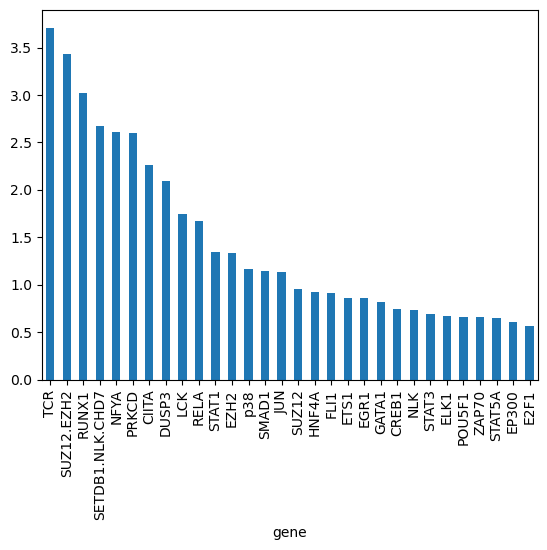

In [42]:
gene_biases_score.head(30).plot.bar()

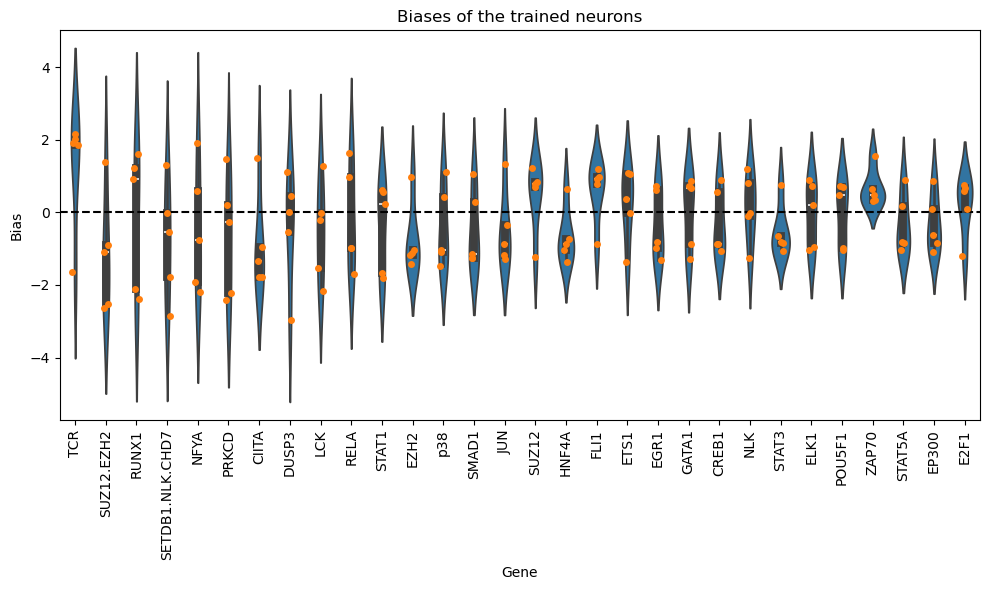

In [43]:
# Get the top genes sorted by mean bias
top_genes = gene_biases_score.head(30).index

# Filter the DataFrame to include only rows with these top genes
filtered_df = df_biases_prunedr[df_biases_prunedr['gene'].isin(top_genes)]

plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x="gene", y="bias", order=top_genes, dodge=True)
sns.stripplot(data=filtered_df, x="gene", y="bias", order=top_genes, dodge=True)
plt.xticks(rotation=90)
plt.title('Biases of the trained neurons')
plt.xlabel('Gene')
plt.ylabel('Bias')
plt.axhline(0, linestyle="--", color="k")
plt.tight_layout()

In [44]:
param_compression = (1-(pruned_models[0].count_params()/models[0].count_params())) * 100
print(f"Parameter compression: {param_compression:.2f}%")

Parameter compression: 51.28%


In [45]:
perf_degradation = ((np.mean(metrics["roc_auc"]) - np.mean(pruned_metrics["roc_auc"])) / np.mean(metrics["roc_auc"])) * 100
print(f"Degradation in ROC-AUC after compression (positive = decrease in performance, negative = increase in performance): {perf_degradation:.2f}%")

Degradation in ROC-AUC after compression (positive = decrease in performance, negative = increase in performance): 0.09%
